# Feature Engineering

## Introducción
La ingeniería de características es una etapa crucial en la creación de modelos predictivos. En esta notebook, se crearán y seleccionarán características relevantes que capturen comportamiento de default.


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 2. Configuración del Entorno

In [2]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)

# Configuración de estilo para las visualizaciones
sns.set(style="whitegrid")

# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [3]:
# Cargar los datos desde archivos CSV
df = pd.read_parquet(f'{data_dir}complete_data.parquet')
df_vd = pd.read_parquet(f'{data_dir}complete_data_vd.parquet')

print(df.shape,df_vd.shape)
df.head()

(223983, 10) (223983, 3)


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0,2020-11-30,29,-5.0
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0,2020-11-30,55,-30.0
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0,2020-11-30,29,-4.0
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0,2020-11-30,32,-7.0
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0,2020-11-30,29,-5.0


## 4. Preparacion de la base

In [4]:
df_vd.head()

,id,fecha_observacion,vd
0,0,2020-11-30,0
1,1,2020-11-30,0
2,1,2020-12-31,0
3,2,2020-11-30,0
4,2,2020-12-31,0


In [6]:
df['fecha_observacion']=pd.to_datetime(df['fecha_corte'])
df_vd['fecha_observacion']=pd.to_datetime(df_vd['fecha_observacion'])

df_merge=df_vd.merge(df,on=["id","fecha_observacion"])
df_merge.shape

(223983, 12)

In [7]:
df_desarrollo=df_merge[(df_merge["fecha_observacion"]<="2021-12-31")].copy()

df_validacion_operacional=df_merge[(df_merge["fecha_observacion"]=="2022-01-31")].copy()

df_desarrollo.shape,df_validacion_operacional.shape

((161287, 12), (14223, 12))

In [9]:
from sklearn.model_selection import train_test_split

# para evitar tener ids en desarrollo y validacion parte la base por ids

# se va dividir en tres bases, si bien para modelo de regresion logistica se emplea normalmente dos, desarrollo y validacion
# en machine learning se utiliza una base para validar los hiperparametros 


tran_test,val= train_test_split(df_desarrollo['id'].unique(), shuffle=True,test_size=0.20, random_state=42)
tran,test= train_test_split(tran_test, shuffle=True,test_size=0.20, random_state=42)

len(tran),len(test),len(val)

(44102, 11026, 13783)

In [10]:
df_resumen=df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(tran))].pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,1828,0,0,0,0.000000
2020-12-31,3356,11,0,0,0.003267
2021-01-31,5405,23,0,0,0.004237
2021-02-28,6218,31,0,0,0.004961
2021-03-31,6430,60,0,0,0.009245
2021-04-30,6173,85,0,0,0.013583
2021-05-31,7109,135,0,0,0.018636
2021-06-30,7634,199,0,0,0.025405
2021-07-31,8505,328,1,3,0.037133


In [11]:
df_resumen=df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(test))].pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,449,0,0,0,0.000000
2020-12-31,778,1,0,0,0.001284
2021-01-31,1271,4,0,0,0.003137
2021-02-28,1516,8,0,0,0.005249
2021-03-31,1610,15,0,0,0.009231
2021-04-30,1523,21,0,0,0.013601
2021-05-31,1799,35,0,0,0.019084
2021-06-30,1921,49,0,0,0.024873
2021-07-31,2183,79,0,0,0.034925


In [13]:
df_resumen=df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(val))].pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,558,0,0,0,0.000000
2020-12-31,1003,2,0,0,0.001990
2021-01-31,1665,5,0,0,0.002994
2021-02-28,1889,11,0,0,0.005789
2021-03-31,2016,20,0,0,0.009823
2021-04-30,1930,29,0,0,0.014803
2021-05-31,2252,37,0,0,0.016164
2021-06-30,2470,61,0,0,0.024101
2021-07-31,2717,96,0,0,0.034127


In [14]:
# se observa que las tres bases tienen similar distribucion 

df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(tran))].to_parquet(f'{data_dir}bd_train.parquet')
df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(test))].to_parquet(f'{data_dir}bd_test.parquet')
df_merge[(df_merge["fecha_observacion"]<="2021-12-31")&(df_merge['id'].isin(val))].to_parquet(f'{data_dir}bd_val.parquet')

df_validacion_operacional.to_parquet(f'{data_dir}bd_validacion_operacional.parquet')

## 5. Feature Engineering

In [15]:
df_train=pd.read_parquet(f'{data_dir}bd_train.parquet')
df_test=pd.read_parquet(f'{data_dir}bd_test.parquet')
df_val=pd.read_parquet(f'{data_dir}bd_val.parquet')
df_vo=pd.read_parquet(f'{data_dir}bd_validacion_operacional.parquet')

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 12), (25668, 12), (32405, 12), (14223, 12))

In [16]:
df_train.head(3)

,id,fecha_observacion,vd,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-30,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0,2020-11-30,29,-5.0
1,1,2020-11-30,0,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0,2020-11-30,55,-30.0
2,1,2020-12-31,0,2020-11-05,2020-12-30,2020-12-28,Relacionados a Construccion,5,88155.0,2020-12-31,55,-2.0


### Variables Categoricas

In [17]:
## Generacion de variables de probabilidad

def segmentos(df,var_analisis='payerSalesSegment',vd='vd'):
    df_tmp=df[df[vd].isin([0,1])].groupby(var_analisis).agg(
    malos=('vd','sum'),
    total=('vd','size')
)
    df_tmp['bad_rate']=df_tmp['malos']/df_tmp['total']
    df_tmp['porcentaje']=df_tmp['total']/df_tmp['total'].sum()

    return df_tmp.sort_values('bad_rate')

In [18]:
segmentos(df_train,var_analisis='payerSalesSegment',vd='vd')

,malos,total,bad_rate,porcentaje
payerSalesSegment,,,,
6,64,26771,0.002391,0.261186
5,1286,63548,0.020237,0.619993
3,615,5317,0.115667,0.051874
4,535,4503,0.118810,0.043933
1,169,1093,0.154620,0.010664
2,280,1266,0.221169,0.012351


In [19]:
tmp=df_train.copy()

In [24]:
# se decide agrupar de este modo para generar una variable monotona 
tmp["prbm_payerSalesSegment"]=np.where(tmp["payerSalesSegment"].isin([6]),0.002279,
np.where(tmp["payerSalesSegment"].isin([5]),0.020237,
np.where(tmp["payerSalesSegment"].isin([3,4]),0.114088,0.169334
)))

In [25]:
segmentos(tmp,var_analisis='prbm_payerSalesSegment',vd='vd')
    

,malos,total,bad_rate,porcentaje
prbm_payerSalesSegment,,,,
0.002279,64,26771,0.002391,0.261186
0.020237,1286,63548,0.020237,0.619993
0.114088,1150,9820,0.117108,0.095807
0.169334,449,2359,0.190335,0.023015


In [26]:
tmp["prbm_payerSalesSegment"]=np.where(tmp["payerSalesSegment"].isin([6]),0.002391,
np.where(tmp["payerSalesSegment"].isin([5]),0.020237,
np.where(tmp["payerSalesSegment"].isin([3,4]),0.117108,0.190335
)))

In [27]:
segmentos(tmp,var_analisis='sector',vd='vd')

,malos,total,bad_rate,porcentaje
sector,,,,
Laboratorios y Fabricación Productos Farmacéuticos,0,63,0.000000,0.000623
Aerolíneas,0,3,0.000000,0.000030
Suministro de Agua,0,314,0.000000,0.003103
Combustibles y Gas,0,87,0.000000,0.000860
Servicios de Salud,0,332,0.000000,0.003281
Seguros e Isapres,0,10630,0.000000,0.105045
Retail,37,15407,0.002402,0.152251
Ganadería,25,8567,0.002918,0.084658
Minería y Metales,15,3159,0.004748,0.031217


In [28]:
segmentos(tmp,var_analisis='sector',vd='vd').iloc[21:27].index
    


Index(['Consumo Basico', 'Maquinaria y Equipo', 'Servicios',
       'Industria Automotriz', 'Comercio', 'Gobierno y Actividades Sociales'],
      dtype='object', name='sector')

In [29]:
sector_1=['Laboratorios y Fabricación Productos Farmacéuticos', 'Aerolíneas',
       'Suministro de Agua', 'Combustibles y Gas', 'Servicios de Salud',
       'Seguros e Isapres', 'Medios de Comunicación', 'Quimicos y Maderas']

sector_2=['Retail', 'Ganadería', 'Acuicultura y Pesca', 'Minería y Metales']

sector_3=['Construcción Ingeniería e Infraestructura']

sector_4=['Hoteles, Restaurantes y Ocio', 'Agricultura y Relacionados',
       'Telecomunicaciones', 'Mercados de Capitales', 'Transporte',
       'Envíos y Almacenamiento', 'Energía', 'Relacionados a Construccion']

sector_5=['Comercio', 'Consumo Basico', 'Servicios',
       'Tecnología de la Información', 'Gobierno y Actividades Sociales',
       'Maquinaria y Equipo','Industria Automotriz']

sector_6=['Educación', 'Construcción de Viviendas', 'Tabaco']

tmp["prbm_sector"]=np.where(tmp["sector"].isin(sector_1),0.1,
np.where(tmp["sector"].isin(sector_2),0.2,
np.where(tmp["sector"].isin(sector_3),0.3,
np.where(tmp["sector"].isin(sector_4),0.4,
np.where(tmp["sector"].isin(sector_5),0.5,
np.where(tmp["sector"].isin(sector_6),0.6,0.7
))))))

segmentos(tmp,var_analisis='prbm_sector',vd='vd')

,malos,total,bad_rate,porcentaje
prbm_sector,,,,
0.1,25,14673,0.001704,0.143154
0.2,128,35813,0.003574,0.349402
0.3,135,21638,0.006239,0.211107
0.4,249,10266,0.024255,0.100158
0.5,880,13506,0.065156,0.131768
0.7,112,1303,0.085955,0.012712
0.6,1420,5299,0.267975,0.051699


### Variables Numericas

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Profundidad del árbol: 3
Número de nodos terminales: 7


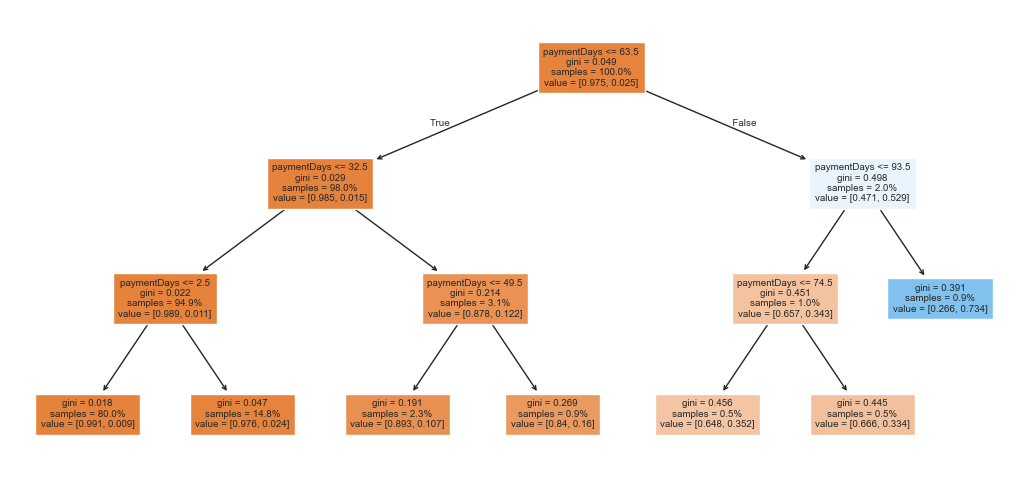

In [163]:
var='paymentDays'

X_train=df_train[df_train['vd'].isin([0,1])][[var]]
y_train=df_train[df_train['vd'].isin([0,1])]['vd']

modelo = DecisionTreeClassifier(
            max_depth         = 3,
            criterion         = 'gini',
            random_state      = 123,
            min_samples_split =0.005,
            min_samples_leaf =0.005
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

# Estructura del árbol creado
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = [var],
            #class_names   = var,
            filled        = True,
            impurity      = True,
            fontsize      = 7,
            proportion    = True,
            ax            = ax
       )

In [165]:
    tmp["prbm_paymentDays"]=np.where(tmp["paymentDays"]<=2,0.1,
    np.where(tmp["paymentDays"]<=32,0.2,
    np.where(tmp["paymentDays"]<=49,0.3,
    np.where(tmp["paymentDays"]<=63,0.4,
    np.where(tmp["paymentDays"]<=93,0.5,0.6
    )))))

segmentos(tmp,var_analisis='prbm_paymentDays',vd='vd')
    

,malos,total,bad_rate,porcentaje
prbm_paymentDays,,,,
0.1,730,81718,0.008933,0.800309
0.2,367,15153,0.024220,0.148402
0.3,248,2323,0.106759,0.022750
0.4,143,891,0.160494,0.008726
0.5,363,1058,0.343100,0.010362
0.6,708,965,0.733679,0.009451


In [31]:
df_train.shape

(103214, 12)

In [215]:
# se observa null pero son 5 de 103214, para simiplificar imputamos por la media 
df_train[df_train["amountFinanced"].isnull()].shape

(5, 21)

In [32]:
df_train[~df_train["amountFinanced"].isnull()]['amountFinanced'].median()

713881.0

In [33]:
df_test.select_dtypes(include=['number']).describe(percentiles=[0.001,0.999]).T

,count,mean,std,min,0.1%,50%,99.9%,max
id,25668.0,3.198582e+04,1.864004e+04,11.0,115.0,31698.5,6.877600e+04,68909.0
vd,25668.0,5.501013e-02,3.498952e-01,0.0,0.0,0.0,4.000000e+00,4.0
payerSalesSegment,25668.0,5.019402e+00,9.237147e-01,1.0,1.0,5.0,6.000000e+00,6.0
amountFinanced,25668.0,5.689737e+06,2.188754e+07,0.0,5000.0,728215.0,2.914799e+08,750000000.0
expirationDays,25668.0,4.739325e+01,2.683229e+01,-9.0,5.0,38.0,1.460000e+02,178.0
paymentDays,25668.0,-1.133575e+01,3.324216e+01,-369.0,-178.0,-10.0,2.043330e+02,296.0


In [51]:
def att(tmp):
    tmp["prbm_payerSalesSegment"]=np.where(tmp["payerSalesSegment"].isin([6]),0.002391,
    np.where(tmp["payerSalesSegment"].isin([5]),0.020237,
    np.where(tmp["payerSalesSegment"].isin([3,4]),0.117108,0.190335
    )))

    tmp['expirationDays'] = (tmp['expirationDate'] - tmp['date']).dt.days
    tmp['paymentDays'] = np.where(tmp['paymentDate'].isnull(),(tmp['fecha_observacion'] - tmp['expirationDate']).dt.days, # fecha de corte "foto"
                                (tmp['paymentDate'] - tmp['expirationDate']).dt.days)
    
    tmp['date_paymentDays']=tmp['expirationDays']+tmp['paymentDays']
    
    tmp["prbm_sector"]=np.where(tmp["sector"].isin(sector_1),0.000409,
    np.where(tmp["sector"].isin(sector_2),0.002683,
    np.where(tmp["sector"].isin(sector_3),0.005458,
    np.where(tmp["sector"].isin(sector_4),0.023589,
    np.where(tmp["sector"].isin(sector_5),0.050891,
    np.where(tmp["sector"].isin(sector_6),0.259167,0.050239
    ))))))

    tmp['amountFinanced']=np.where(tmp['amountFinanced'].isnull(),713881,tmp['amountFinanced'])

    var_numeric=['amountFinanced','expirationDays','paymentDays','date_paymentDays']

    for var in var_numeric:

        tmp[f"{var}_log_abs"]= np.sign(tmp[var]) * np.log(np.abs(tmp[var]) + 1)
        tmp[f"{var}_sqrt_modified"]= np.sign(tmp[var]) * np.sqrt(np.abs(tmp[var]))

    tmp["prbm_paymentDays"]=np.where(tmp["paymentDays"]<=2,0.008933,
    np.where(tmp["paymentDays"]<=32,0.024220,
    np.where(tmp["paymentDays"]<=49,0.106759,
    np.where(tmp["paymentDays"]<=63,0.160494,
    np.where(tmp["paymentDays"]<=93,0.343100,0.733679
    )))))

    return tmp

# se podria generar generar mas features como ser, el promedio de amountFinanced por sector de los que no estan en default y luego calcular la diferencia con cada factura, 
# features multiplicativas , ejemplo generar variables one hot encoder de sector y multiplicar por el amountFinanced
# por cuestiones de practiva avanzamos con estas variables 


In [52]:
df_train=att(df_train)
df_test=att(df_test)
df_val=att(df_val)
df_vo=att(df_vo)

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 27), (25668, 27), (32405, 27), (14223, 27))

## 6. Feature selection

In [53]:
# Existes diferentes herramientas para seleccionar variables , una podria las que tienen mayor correlacion con la vd
df_train[df_train['vd'].isin([0,1])].select_dtypes(include=['number']).corr()[['vd']]

,vd
id,-0.011325
vd,1.000000
payerSalesSegment,-0.217340
amountFinanced,0.007784
expirationDays,0.080551
paymentDays,0.280283
prbm_payerSalesSegment,0.237433
prbm_sector,0.358016
amountFinanced_log_abs,0.080738
amountFinanced_sqrt_modified,0.052946


In [54]:
import pandas as pd
import numpy as np

def select_uncorrelated_features(df_, vd, corr_threshold=0.9, iv_threshold=0.02, vd_corr_threshold=0.1):
    """
    Selecciona las características que no están altamente correlacionadas entre sí, 
    manteniendo la que tiene mayor correlación con la variable dependiente (VD).
    Primero, filtra las variables que tienen baja correlación o bajo IV con la VD.

    Args:
        df_ (pd.DataFrame): DataFrame con las características y la variable dependiente.
        vd (str): Nombre de la variable dependiente en el DataFrame.
        corr_threshold (float): Umbral de correlación para considerar características como altamente correlacionadas.
        iv_threshold (float): Umbral de IV por debajo del cual las variables serán eliminadas (si aplicas IV).
        vd_corr_threshold (float): Umbral de correlación con la VD por debajo del cual las variables serán eliminadas.

    Returns:
        list: Lista de nombres de características seleccionadas.
    """

    # Paso 1: Filtrar características con baja correlación con la VD
    corr_with_vd = df_.drop(columns=[vd]).corrwith(df_[vd]).abs()
    high_corr_features = corr_with_vd[corr_with_vd >= vd_corr_threshold].index.tolist()

    if len(high_corr_features) == 0:
        print(f"Ninguna característica tiene correlación mayor que {vd_corr_threshold} con la VD.")
        return []

    # Mantener sólo las características con alta correlación con la VD
    filtered_df = df_[high_corr_features + [vd]]  # Mantener las características filtradas y la VD
    
    # Paso 2: Calcular la matriz de correlación entre las características filtradas
    corr_matrix = filtered_df.drop(columns=[vd]).corr().abs()

    # Inicializar una lista para almacenar las características a mantener
    selected_features = set()

    # Lista para almacenar características que ya han sido evaluadas
    evaluated_features = set()
    
    # Iterar sobre la matriz de correlación para identificar características altamente correlacionadas
    for i in range(len(corr_matrix.columns)):
        feature_i = corr_matrix.columns[i]
        
        if feature_i in evaluated_features:
            continue
            
        # Encontrar las características altamente correlacionadas con la característica actual
        highly_corr_features = corr_matrix.columns[(corr_matrix.iloc[:, i] > corr_threshold) & 
                                                   (corr_matrix.columns != feature_i)].tolist()
        
        # Añadir la característica actual a la lista de evaluadas
        evaluated_features.add(feature_i)
        
        if highly_corr_features:
            # Incluir la característica actual como parte del grupo correlacionado
            highly_corr_features.append(feature_i)
            
            # Evaluar la correlación con la variable dependiente (VD)
            correlations_with_vd = filtered_df[highly_corr_features].corrwith(df_[vd]).abs()
            
            # Seleccionar la característica con la mayor correlación con la VD
            best_feature = correlations_with_vd.idxmax()
            
            # Añadir esta característica a la lista de seleccionadas
            selected_features.add(best_feature)
            
            # Marcar todas las características del grupo como evaluadas
            evaluated_features.update(highly_corr_features)
        else:
            # Si no hay características altamente correlacionadas, seleccionar la actual
            selected_features.add(feature_i)
    
    # Devolver la lista de características seleccionadas
    return list(selected_features)

In [55]:
# esta es una tecnica que selecciona variables que la correlacion entre ellas sean menor a 0.7 ("correlacion debil")


VD="vd"
varsstep=select_uncorrelated_features(df_train[df_train['vd'].isin([0,1])].select_dtypes("number").drop(columns=['id']) , 
                                      VD,
                                    corr_threshold=0.7,
                                    vd_corr_threshold=0.01)
len(varsstep),varsstep

(7,
 ['prbm_payerSalesSegment',
  'date_paymentDays',
  'amountFinanced_log_abs_cap',
  'prbm_paymentDays',
  'paymentDays_cap',
  'expirationDays_log_abs_cap',
  'prbm_sector'])

In [56]:
df_train[varsstep].describe(percentiles=[0.001,0.999]).T

,count,mean,std,min,0.1%,50%,99.9%,max
prbm_payerSalesSegment,103214.0,0.029344,0.040474,0.002391,0.002391,0.020237,0.190335,0.190335
date_paymentDays,103214.0,36.268965,34.910147,-308.000000,-7.787000,27.000000,279.000000,384.000000
amountFinanced_log_abs_cap,103214.0,13.628430,1.958580,0.000000,7.904335,13.478473,19.615741,22.000000
prbm_paymentDays,103214.0,0.026322,0.084518,0.008933,0.008933,0.008933,0.733679,0.733679
paymentDays_cap,103214.0,-11.659843,32.231349,-178.000000,-178.000000,-10.000000,203.000000,203.000000
expirationDays_log_abs_cap,103214.0,3.736943,0.570148,1.790000,1.791759,3.688879,5.080000,5.080000
prbm_sector,103214.0,0.025500,0.057419,0.000409,0.000409,0.005458,0.259167,0.259167


In [57]:
## este proceso es muy importante para variables continuas en la rl
def att_capping(tmp):

    tmp["paymentDays_cap"]=tmp["paymentDays"].clip(lower=-178, upper=203)
    tmp["date_paymentDays_cap"]=tmp["date_paymentDays"].clip(lower=-7, upper=280)
    tmp["amountFinanced_log_abs_cap"]=tmp["amountFinanced_log_abs"].clip(lower=0, upper=22)
    tmp["expirationDays_log_abs_cap"]=tmp["expirationDays_log_abs"].clip(lower=1.79, upper=5.08)


    return tmp

In [58]:
df_train=att_capping(df_train)
df_test=att_capping(df_test)
df_val=att_capping(df_val)
df_vo=att_capping(df_vo)

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 28), (25668, 28), (32405, 28), (14223, 28))

In [59]:
# guardo base
df_train.to_parquet(f'{data_dir}df_train_att.parquet')
df_test.to_parquet(f'{data_dir}df_test_att.parquet')
df_val.to_parquet(f'{data_dir}df_val_att.parquet')
df_vo.to_parquet(f'{data_dir}df_vo_att.parquet')

### Conclusión Final: Feature Engineering

1. **División de la base por IDs:**
   - Para evitar la presencia de IDs compartidos entre las bases de desarrollo y validación, se realizó la partición por IDs únicos.
   - Se dividió la base en tres conjuntos:
     - **Desarrollo:** para entrenar el modelo.
     - **Validación:** para evaluar el desempeño del modelo.
     - **Prueba:** utilizada para validar hiperparámetros y obtener métricas finales.
   - Las tres bases presentan una distribución similar en el `bad rate` por fecha de observación, garantizando la representatividad de cada conjunto.

2. **Generación de variables (Feature Engineering):**
   - Se exploraron y se generaron algunas features pero se podria considerar algunas otras en un futuro, como ser:
     - El promedio de `amountFinanced` por sector para los registros sin default, comparado con cada factura individual.
     - Variables multiplicativas, como la combinación de variables one-hot encoded de `sector` con `amountFinanced`.
   - Por cuestiones prácticas y para optimizar el tiempo, se avanzó con un conjunto inicial de variables, dejando la posibilidad de expandirlas en futuras iteraciones.

3. **Selección de variables:**
   - Para elegir las mejores características se utilizaron técnicas basadas en correlación:
     - Se seleccionaron variables cuya correlación entre sí fuera menor a 0.7 ("correlación débil") para evitar redundancia.
     - En caso de correlación alta entre variables (>0.7), se retuvo la variable con mayor correlación con la variable dependiente (`VD`).
   - Este enfoque garantiza un conjunto de variables más independiente y relevante para el modelo.

4. **Capping de variables continuas:**
   - Se aplicó capping a las variables continuas seleccionadas. Este paso es crucial para la estabilidad del modelo, especialmente en el caso de regresiones logísticas, donde los valores extremos pueden afectar negativamente el desempeño.

---

Con estas decisiones, el conjunto de variables queda preparado para ser utilizado en el modelado, asegurando relevancia, estabilidad y capacidad predictiva. En futuras iteraciones, se podrían generar y evaluar nuevas características para mejorar el desempeño del modelo.
